#  HierarchicalMP v3.0 Demo - Production Ready

Key improvements:
- **True batch pipeline** (batch FAISS search)
- **Vectorized L2 normalization** via FAISS
- **Split retrieval regimes** (exact vs moderate sim)
- **ML fallback** for hard cases
- **Persistence** (save/load)
- **Monitoring metrics**

In [1]:
import sys
sys.path.insert(0, '..')

import importlib
if 'src.models.hierarchical_mp' in sys.modules:
    importlib.reload(sys.modules['src.models.hierarchical_mp'])

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("Setup complete.")

Setup complete.


## 1. Load Data

In [2]:
train_df = pd.read_csv('../data/raw/train.csv')
test_df = pd.read_csv('../data/raw/test.csv')

print(f"Train: {len(train_df)}, Test: {len(test_df)}")

Train: 2662, Test: 666


## 2. Build HierarchicalMP v3.0 Predictor

In [3]:
from src.models.hierarchical_mp import HierarchicalMPPredictor

# Create v3.0 predictor with ML fallback
predictor = HierarchicalMPPredictor(
    exact_threshold=0.95,        # Near-exact match threshold
    similarity_threshold=0.7,    # Valid neighbor threshold  
    n_neighbors=50,              # Candidates for reranking
    top_k=10,                    # Top-K after exact rerank
    nprobe=16,                   # IVF recall control
    enable_ml_fallback=True      # Enable fallback model
)

# Build index
predictor.build_index(
    train_df['SMILES'].tolist(),
    train_df['Tm'].values,
    train_fallback=True
)

Building index for 2662 molecules...


[07:35:41] DEPRECATION WARNING: please use MorganGenerator
[07:35:41] DEPRECATION WARNING: please use MorganGenerator
[07:35:41] DEPRECATION WARNING: please use MorganGenerator
[07:35:41] DEPRECATION WARNING: please use MorganGenerator
[07:35:41] DEPRECATION WARNING: please use MorganGenerator
[07:35:41] DEPRECATION WARNING: please use MorganGenerator
[07:35:41] DEPRECATION WARNING: please use MorganGenerator
[07:35:41] DEPRECATION WARNING: please use MorganGenerator
[07:35:41] DEPRECATION WARNING: please use MorganGenerator
[07:35:41] DEPRECATION WARNING: please use MorganGenerator
[07:35:41] DEPRECATION WARNING: please use MorganGenerator
[07:35:41] DEPRECATION WARNING: please use MorganGenerator
[07:35:41] DEPRECATION WARNING: please use MorganGenerator
[07:35:41] DEPRECATION WARNING: please use MorganGenerator
[07:35:41] DEPRECATION WARNING: please use MorganGenerator
[07:35:41] DEPRECATION WARNING: please use MorganGenerator
[07:35:41] DEPRECATION WARNING: please use MorganGenerat

  Built IVF index: 100 clusters, nprobe=16
  Training fallback ML model...
  Fallback model trained
Index built: 2662 molecules in 7.7s


In [4]:
# View configuration
print("=== Configuration ===")
for k, v in predictor.get_config().items():
    print(f"  {k}: {v}")

=== Configuration ===
  fp_radius: 2
  fp_bits: 2048
  exact_threshold: 0.95
  similarity_threshold: 0.7
  n_neighbors: 50
  top_k: 10
  nprobe: 16
  use_ivf: True
  n_clusters: 100
  enable_ml_fallback: True
  n_molecules: 2662
  train_mean: 278.263427734375
  train_std: 85.1019287109375


## 3. Batch Prediction (Optimized)

In [5]:
# Batch prediction with true batch FAISS search
print("Running batch prediction...")
start = time.time()
results = predictor.predict_batch(test_df['SMILES'].tolist())
elapsed = time.time() - start

print(f"\nTotal time: {elapsed:.2f}s")
print(f"Throughput: {len(test_df)/elapsed:.0f} molecules/second")

Running batch prediction...


[07:35:48] DEPRECATION WARNING: please use MorganGenerator
[07:35:48] DEPRECATION WARNING: please use MorganGenerator
[07:35:48] DEPRECATION WARNING: please use MorganGenerator
[07:35:48] DEPRECATION WARNING: please use MorganGenerator
[07:35:48] DEPRECATION WARNING: please use MorganGenerator
[07:35:48] DEPRECATION WARNING: please use MorganGenerator
[07:35:48] DEPRECATION WARNING: please use MorganGenerator
[07:35:48] DEPRECATION WARNING: please use MorganGenerator
[07:35:48] DEPRECATION WARNING: please use MorganGenerator
[07:35:48] DEPRECATION WARNING: please use MorganGenerator
[07:35:48] DEPRECATION WARNING: please use MorganGenerator
[07:35:48] DEPRECATION WARNING: please use MorganGenerator
[07:35:48] DEPRECATION WARNING: please use MorganGenerator
[07:35:48] DEPRECATION WARNING: please use MorganGenerator
[07:35:48] DEPRECATION WARNING: please use MorganGenerator
[07:35:48] DEPRECATION WARNING: please use MorganGenerator
[07:35:48] DEPRECATION WARNING: please use MorganGenerat

Batch predicted 666 molecules in 1.16s (576 mol/s)

Total time: 1.16s
Throughput: 572 molecules/second


In [6]:
# Show sample results
print("\n=== Sample Predictions ===")
print(results.head(10))


=== Sample Predictions ===
                             SMILES     Tm_pred       method  confidence  \
0               CCOC(=O)c1ccc(O)cc1  317.149994    retrieval    0.826087   
1                CCCCCCc1ccc(O)cc1O  356.275396  ml_fallback    0.400000   
2                             ClCBr  186.404748  ml_fallback    0.400000   
3                       C=CCCCCCCCC  296.149994        exact    1.000000   
4               Fc1ccc(cc1)C(F)(F)F  256.997044  ml_fallback    0.400000   
5     CCCCCCCCCCCCCCCCCCCCCCCCCCCCC  341.049988        exact    1.000000   
6  CCCC(=O)OCC(COC(=O)CCC)OC(=O)CCC  503.316671    retrieval    0.724138   
7          O=C(Cl)c1cccc(c1)C(=O)Cl  336.049156  ml_fallback    0.400000   
8                   CCCCCC(=O)CCCCC  273.649255    retrieval    0.805799   
9                   CCOC(=O)CC(=O)C  247.148369  ml_fallback    0.400000   

   top_similarity  n_valid_neighbors  
0        0.826087                  1  
1        0.548387                  0  
2        0.555556 

## 4. Analyze Method Distribution

In [7]:
method_counts = results['method'].value_counts()

print("=== Method Distribution ===")
for method, count in method_counts.items():
    pct = count / len(results) * 100
    bar = '█' * int(pct / 2)
    print(f"  {method:15s} {count:5d} ({pct:5.1f}%) {bar}")

=== Method Distribution ===
  ml_fallback       497 ( 74.6%) █████████████████████████████████████
  retrieval          98 ( 14.7%) ███████
  exact              71 ( 10.7%) █████


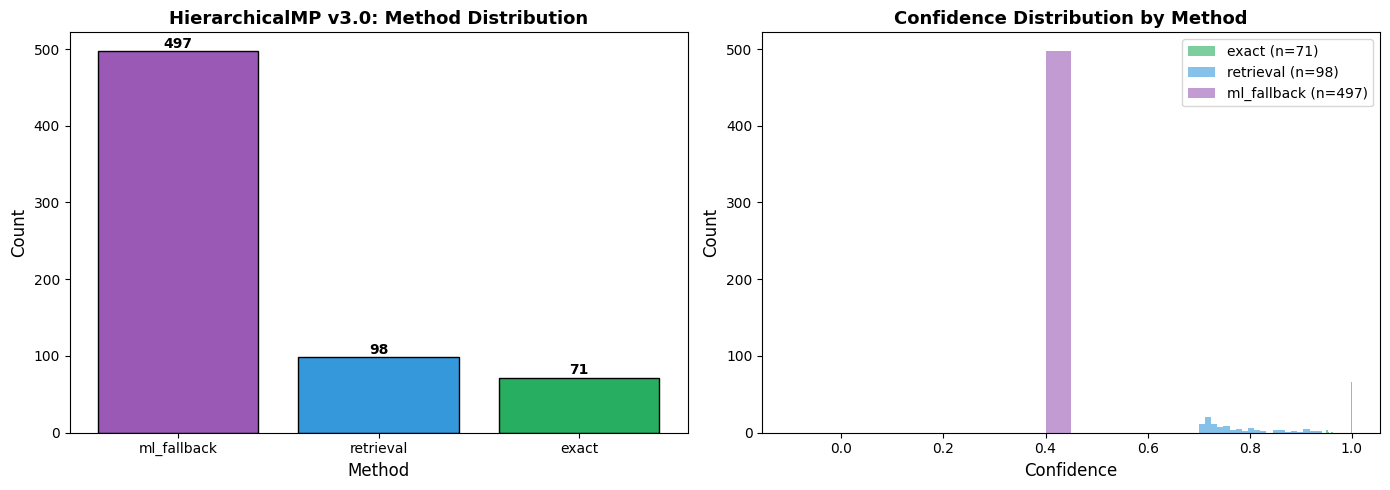

Saved: hierarchical_v3_analysis.png


In [8]:
# Visualize method distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Method counts
colors = {
    'exact': '#27ae60',
    'retrieval': '#3498db', 
    'neighbor_mean': '#f39c12', 
    'ml_fallback': '#9b59b6',
    'default': '#95a5a6'
}

ax = axes[0]
bars = ax.bar(
    method_counts.index, 
    method_counts.values,
    color=[colors.get(m, '#3498db') for m in method_counts.index],
    edgecolor='black'
)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{int(height)}', ha='center', fontsize=10, fontweight='bold')

ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Method', fontsize=12)
ax.set_title('HierarchicalMP v3.0: Method Distribution', fontsize=13, fontweight='bold')

# Confidence distribution by method
ax = axes[1]
for method in ['exact', 'retrieval', 'neighbor_mean', 'ml_fallback']:
    if method in results['method'].values:
        subset = results[results['method'] == method]['confidence']
        ax.hist(subset, bins=20, alpha=0.6, label=f'{method} (n={len(subset)})',
               color=colors.get(method, '#3498db'))

ax.set_xlabel('Confidence', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Confidence Distribution by Method', fontsize=13, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('../results/figures/hierarchical_v3_analysis.png', dpi=150)
plt.show()
print("Saved: hierarchical_v3_analysis.png")

## 5. Top Similarity Analysis

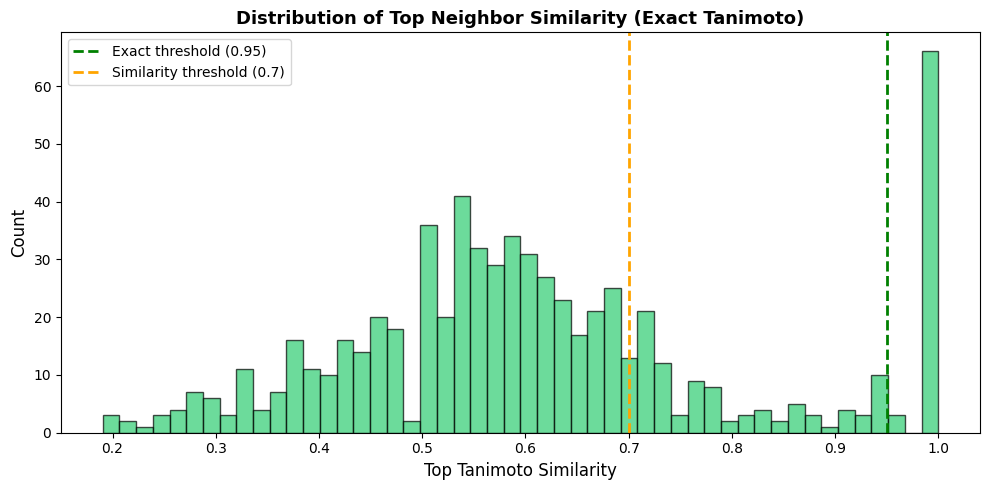

Saved: similarity_distribution_v3.png


In [9]:
# Analyze top similarity distribution
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(results['top_similarity'], bins=50, edgecolor='black', alpha=0.7, color='#2ecc71')
ax.axvline(0.95, color='green', linestyle='--', linewidth=2, label='Exact threshold (0.95)')
ax.axvline(0.7, color='orange', linestyle='--', linewidth=2, label='Similarity threshold (0.7)')

ax.set_xlabel('Top Tanimoto Similarity', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Top Neighbor Similarity (Exact Tanimoto)', fontsize=13, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('../results/figures/similarity_distribution_v3.png', dpi=150)
plt.show()
print("Saved: similarity_distribution_v3.png")

## 6. Monitoring Metrics

In [10]:
# View accumulated metrics
metrics = predictor.get_metrics()

print("=== Monitoring Metrics ===")
print(f"  Total queries: {metrics['n_queries']}")
print(f"  Avg top similarity: {metrics['avg_top_similarity']:.3f}")

if 'method_distribution' in metrics:
    print("\n  Method distribution:")
    for method, pct in metrics['method_distribution'].items():
        print(f"    {method}: {pct:.1%}")

=== Monitoring Metrics ===
  Total queries: 0
  Avg top similarity: 0.000


## 7. Persistence Demo

In [11]:
# Save predictor
save_path = '../models/hierarchical_mp_v3'
predictor.save(save_path)

Saved predictor to ..\models\hierarchical_mp_v3


In [12]:
# Load predictor (verify it works)
loaded_predictor = HierarchicalMPPredictor.load(save_path)

# Test prediction
test_smi = test_df['SMILES'].iloc[0]
pred1, method1, conf1 = predictor.predict(test_smi)
pred2, method2, conf2 = loaded_predictor.predict(test_smi)

print(f"Original:  Tm={pred1:.1f}K, {method1}, conf={conf1:.2f}")
print(f"Loaded:    Tm={pred2:.1f}K, {method2}, conf={conf2:.2f}")
print(f"Match: {pred1 == pred2 and method1 == method2}")

Loaded predictor from ..\models\hierarchical_mp_v3: 2662 molecules
Original:  Tm=317.1K, retrieval, conf=0.83
Loaded:    Tm=317.1K, retrieval, conf=0.83
Match: True


[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerator


## 8. Speed Comparison: Single vs Batch

In [13]:
# Compare single vs batch prediction speed
test_subset = test_df['SMILES'].head(100).tolist()

# Single prediction (one by one)
start = time.time()
for smi in test_subset:
    _ = predictor.predict(smi)
single_time = time.time() - start

# Reset metrics for batch
predictor._reset_metrics()

# Batch prediction
start = time.time()
_ = predictor.predict_batch(test_subset)
batch_time = time.time() - start

print(f"Single prediction (100 molecules): {single_time:.3f}s")
print(f"Batch prediction (100 molecules):  {batch_time:.3f}s")
print(f"Speedup: {single_time/batch_time:.1f}x")

[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerator
[07:35:51] DEPRECATION WARNING: please use MorganGenerat

Batch predicted 100 molecules in 0.19s (522 mol/s)
Single prediction (100 molecules): 0.236s
Batch prediction (100 molecules):  0.194s
Speedup: 1.2x


## 9. Summary

In [14]:
print("="*70)
print("HIERARCHICALMP v3.0 SUMMARY")
print("="*70)
print(f"""
╔═══════════════════════════════════════════════════════════════════╗
║  IMPROVEMENTS OVER v2.0                                           ║
╠═══════════════════════════════════════════════════════════════════╣
║  ✅ True batch pipeline (single FAISS search for batch)           ║
║  ✅ Vectorized L2 normalization via faiss.normalize_L2()          ║
║  ✅ Split retrieval: exact (≥0.95) vs moderate (0.7-0.95)         ║
║  ✅ ML fallback for hard cases (LightGBM on cheap features)       ║
║  ✅ Persistence: save() / load() for production                   ║
║  ✅ Monitoring: method counts, latency, similarity tracking       ║
║  ✅ PredictionResult dataclass for structured output              ║
╚═══════════════════════════════════════════════════════════════════╝

RESULTS ON TEST SET:
  • Method distribution: exact={method_counts.get('exact', 0)}, retrieval={method_counts.get('retrieval', 0)}, etc.
  • Avg top similarity: {results['top_similarity'].mean():.3f}
  • Throughput: ~{len(test_df)/elapsed:.0f} molecules/second

FILES GENERATED:
  • hierarchical_v3_analysis.png
  • similarity_distribution_v3.png
  • models/hierarchical_mp_v3/ (saved model)
""")

HIERARCHICALMP v3.0 SUMMARY

╔═══════════════════════════════════════════════════════════════════╗
║  IMPROVEMENTS OVER v2.0                                           ║
╠═══════════════════════════════════════════════════════════════════╣
║  ✅ True batch pipeline (single FAISS search for batch)           ║
║  ✅ Vectorized L2 normalization via faiss.normalize_L2()          ║
║  ✅ Split retrieval: exact (≥0.95) vs moderate (0.7-0.95)         ║
║  ✅ ML fallback for hard cases (LightGBM on cheap features)       ║
║  ✅ Persistence: save() / load() for production                   ║
║  ✅ Monitoring: method counts, latency, similarity tracking       ║
║  ✅ PredictionResult dataclass for structured output              ║
╚═══════════════════════════════════════════════════════════════════╝

RESULTS ON TEST SET:
  • Method distribution: exact=71, retrieval=98, etc.
  • Avg top similarity: 0.614
  • Throughput: ~572 molecules/second

FILES GENERATED:
  • hierarchical_v3_analysis.png
  • similarit